In [46]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.constants import physical_constants
import tinyarray

In [47]:
h_bar = physical_constants['Planck constant over 2 pi'][0]   
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]             
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  
mu_B = physical_constants['Bohr magneton'][0]  
mu_B = mu_B/eV_unit
g = 200 

In [48]:
m_ef = 0.1* m_el
dx = 1 * 10**(-9) 
alfa = 0
Bh = 0.05
Bext = 0
t_unit_J = h_bar**(2)/(2*m_ef*dx**2) 
t = t_unit_J/eV_unit 
W = 30
L = 1000
t_so = alfa/(2*dx)

In [49]:
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])
sigma_law = np.matrix([[1, 0], [0, 2]])

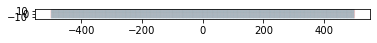

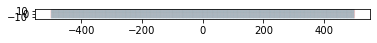

In [50]:
def make_system(Bext = 0):  
    x0 = 0
    a = L
    def onsite(site):
        x, y = site.pos
        x = x
        return np.array([[4*t, 0], [0, 4*t]]) + 0.5*g*mu_B*(Bh*np.sin((np.pi*(x-x0))/a)*sigma_x + 0*sigma_y + (Bext + Bh*np.cos((np.pi*(x-x0))/a))*sigma_z)
    
    def onsite_lead(site):
        x, y = site.pos
        x = x
        return np.array([[4*t, 0], [0, 4*t]]) + 0.5*g*mu_B*(Bh*np.sin((np.pi*(x-x0))/a)*sigma_x + 0*sigma_y + (Bext + Bh*np.cos((np.pi*(x-x0))/a))*sigma_z)

    def ribbon(pos):
        x, y = pos
        return -L/2 <= x <= L/2 and -W/2 <= y <= W/2

    def shape_lead(pos):
        x,y = pos
        return (-W/2 < y < W/2)

    def hopping(site1, site2):
        return np.array([[-t,0],[0,-t]])



    sys = kwant.Builder()  
    lat = kwant.lattice.square(dx*10**9, norbs=2)
    sys[lat.shape(ribbon,(0,0))] = onsite
    sys[lat.neighbors()] = hopping



    leadl = kwant.Builder(kwant.TranslationalSymmetry((-dx*10**9,0)),conservation_law=sigma_law)
    leadl[lat.shape(shape_lead, (0,0))] = onsite_lead
    leadl[lat.neighbors()] = hopping

    leadr = kwant.Builder(kwant.TranslationalSymmetry((dx*10**9,0)),conservation_law=sigma_law)
    leadr[lat.shape(shape_lead, (0,0))] = onsite_lead
    leadr[lat.neighbors()] = hopping

    sys.attach_lead(leadl)
    sys.attach_lead(leadr)

    sysf = sys.finalized()

    return sysf
sysf = make_system(0.001)
kwant.plot(sysf)

In [51]:
def disperssion(nr_lead, k_max, nk):
    momenta = np.linspace(-k_max,k_max,nk)
    bands=kwant.physics.Bands(sysf.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta), energies

def conductance(Emax, ne):
    energies=np.linspace(0,Emax,ne)
    cond=[transmission(E) for E in energies]
    return energies, cond

def transmission(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission(1,0) 
    return t

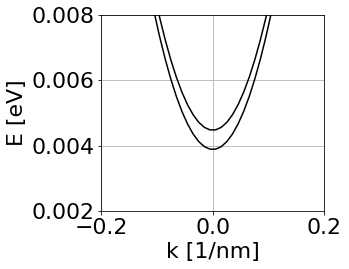

In [52]:
momenta, energies = disperssion(0, 1, 200)
plt.figure(figsize=(4,4))
plt.plot(momenta, np.asarray(energies),'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylim((0.002,.008))  
plt.xlim((-0.2,0.2))  
plt.xlabel("k [1/nm]",fontsize=22)
plt.ylabel("E [eV]",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.grid()
plt.savefig("dyspersja_6jpg.png")
plt.show()

In [53]:
B_max = 0.1
ne = 5
E = 0.0042
B_table = np.linspace(0, B_max, ne)
cond_table = np.zeros(ne)
for index, B in enumerate(B_table):
    sysf = make_system(B)
    try:
        smatrix = kwant.smatrix(sysf, E)
        tran = smatrix.transmission(1, 0)
        cond_table[index] = tran
        print(B)
    except ValueError as e:
        print(f"B={B:.3f} -> smatrix failed: {e}")
        cond_table[index] = 0



0.0
0.025
0.05
0.07500000000000001
0.1


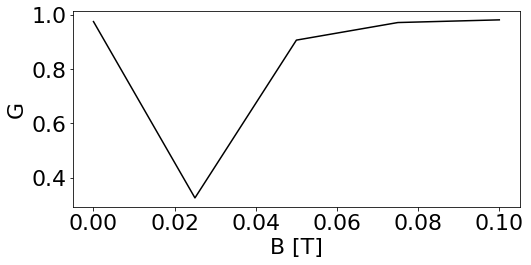

In [54]:
plt.figure(figsize=(8,4))
plt.plot(B_table, cond_table,'k-')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel("B [T]",fontsize=22)
plt.ylabel("G",fontsize=22)
plt.subplots_adjust(bottom=0.2) 
plt.savefig("konduktancja_2.png")
plt.show()